# Reproducing the 1997 LSTM Memory Cell (The "O(1)" Build)


- Aban Hasan (thewildofficial)

This notebook is a step-by-step reproduction of the original **Long Short-Term Memory** architecture introduced by Sepp Hochreiter and Jürgen Schmidhuber in 1997. Our goal is to build the "Memory Cell" from scratch using **tinygrad**, focusing on the exact mathematical formulas and the "Truncation" trick that makes it efficient.

---

## 1. Project Goal
We are building a standalone **LSTM Memory Cell**. Unlike modern deep learning models that use "black box" layers, we are writing every addition and multiplication sequentially.

**The core challenge:** Replicating the "Constant Error Carousel" (CEC) which allows info to stay in memory for 1,000+ timesteps without the computer forgetting or the math "blowing up."

---

## 2. The Original Variables (The Paper’s Notation)
We use the original names from the 1997 paper so your code matches the diagrams:

* **$s_{c_j}$ (Internal State):** The "Safe." This stores the actual value. It has a self-loop of **1.0**, meaning it remembers itself perfectly.
* **$y^{in_j}$ (Input Gate):** The "Entrance Guard." A sigmoid $[0, 1]$ that decides what info gets into the safe.
* **$y^{out_j}$ (Output Gate):** The "Exit Guard." A sigmoid $[0, 1]$ that decides when the cell should "shout" its memory to the next layer.
* **$g$ (Input Squash):** A scaled sigmoid $[-2, 2]$ that cleans up incoming data.
* **$h$ (Output Squash):** A scaled sigmoid $[-1, 1]$ that cleans up the memory before it is spat out.
* **$net$:** The weighted sum (Input $\times$ Weights) before the sigmoid is applied.

---

## 3. The "Scissors" (Truncated Backpropagation)
To keep the complexity at **$O(1)$** (constant work per step), the paper uses a "cheat code" called **Truncation**.

In **tinygrad**, we implement this using `.detach()`:
* **Don't Detach:** The path through $s_c$ (the memory). This allows the error to flow back through time to Step 1.
* **Do Detach:** The path leading into the **Gates**. We tell the computer: *"Use the old memory to decide if the gate should be open, but don't try to calculate the calculus of how that gate was open 500 steps ago."*

---

## 4. Notebook Structure

### Section 1: Setup
* Install `tinygrad` in Colab.
* Import `Tensor` and `numpy`.

### Section 2: The `LSTMCell` Brain
We define a static class that holds our **Long-Term Memory** (the weights). These weights are initialized once and reused for all 1,000 steps.
* `__init__`: Create weight matrices for Input Gate, Output Gate, and Cell State.
* `forward`: The "Factory Line." One step of math ($s_c = s_c + g \cdot y_{in}$).

### Section 3: The 1,000 Step Loop
We write a simple Python `for` loop. We pass the "Safe" ($s_c$) and the "Output" ($h$) from the current step into the next step.
* Notice how we only keep **one** copy of the weights in memory.
* Observe how tinygrad "lazily" builds the To-Do list (the graph) for all 1,000 steps.

### Section 4: The Error & The Tweak
* Calculate the **Loss** (Target - Output).
* Run `.backward()` to "tweak" the weights.
* Explain how the summed gradients from 1,000 steps result in one single update to the "Brain."

---

## 5. The Final "Boss Fight": The Adding Problem
We will test our cell against **Section 5.1** of the paper. If our cell can remember two specific numbers in a sequence of 1,000 and add them together at the very end, we have successfully reproduced the breakthrough.

In [ ]:
# 1. Install clang (the compiler tinygrad needs for CPU/OpenCL)
!apt-get install clang -y
!pip install tinygrad
# 2. Check for GPU and set the Device
import os
#import torch


# CUDA IS BEING A BITCH, SO WE'RE TRAININGLY ONLY ON CPU RN
'''if torch.cuda.is_available():
    os.environ["DEVICE"] = "CUDA"
    print("🚀 GPU detected! tinygrad is now set to use CUDA.")
else:'''

    # If no GPU, we use LLVM or CLANG for CPU
os.environ["DEVICE"] = "LLVM"
print("💻 No GPU found. tinygrad is now set to use CPU (LLVM).")

from tinygrad.tensor import Tensor
from tinygrad.device import Device


# 3. Verify
print(f"Current tinygrad device: {Device.DEFAULT}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
clang is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.
💻 No GPU found. tinygrad is now set to use CPU (LLVM).
Current tinygrad device: CPU


In [ ]:

# testing if tensors actually work (this has nothing to do with the paper, it's just for me to test tinygrad's "lazy" functionality, lol)
T_one = Tensor([1,2,3])
T_two = Tensor([2,4,6])
T_sum = T_one + T_two

print(T_sum.numpy())

[3 6 9]


## High-Level Overview: The Anatomy of the 1997 LSTM Cell

Before we dive into the code, let's look at the "Logical Architecture" of the cell. Think of the LSTM cell as a **High-Security Safe** with two guards and a cleanup crew.

### 1. The Components (The "Box")

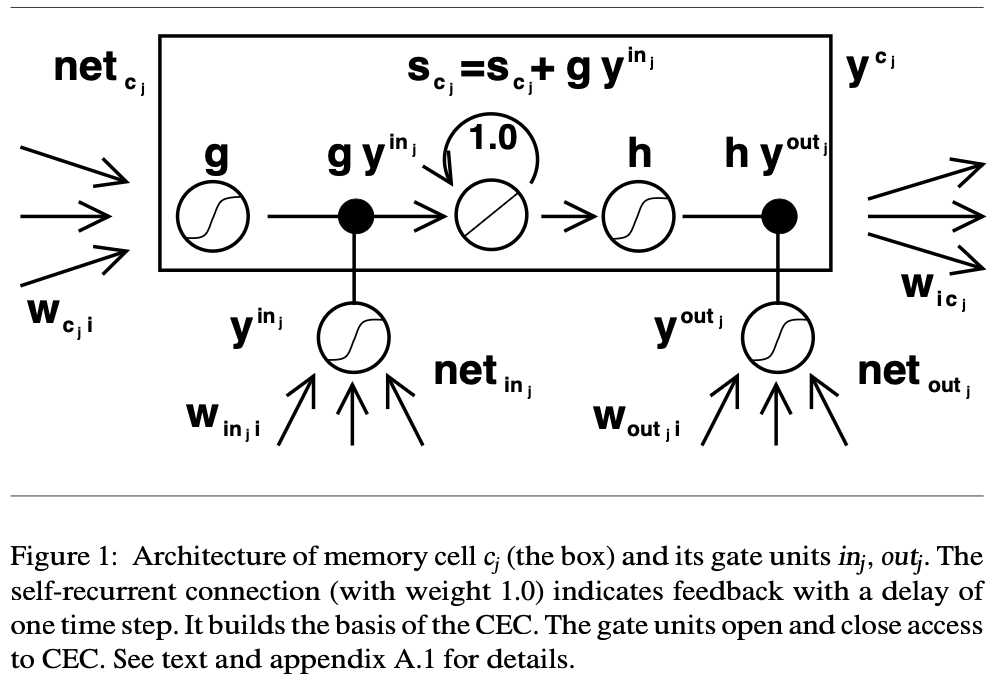
* **The Safe ($s_c$):** This is the **Cell State**. It is a linear unit with a self-connection of weight **1.0**. This is the "Constant Error Carousel" (CEC). Because it is linear and doesn't squash the data, information can stay here for 1,000 steps without decaying.
* **The Guards ($y^{in}$ and $y^{out}$):** These are the **Gating Units**. They use the Logistic Sigmoid function ($0$ to $1$).
    * If the guard is at $0$, the door is locked.
    * If the guard is at $1$, the door is wide open.
* **The Cleanup Crew ($g$ and $h$):** These are the **Squashing Functions**. They ensure that the values entering and leaving the safe stay within a manageable range ($[-2, 2]$ for input, $[-1, 1]$ for output).

### 2. The Logic Flow (The "Forward Pass")
Every time the `forward()` method is called, four things happen in order:

1.  **Check the Guards:** The cell looks at the new input ($x_t$) and the previous hidden state ($h_{t-1}$) to decide how much to open the **Input Gate** and **Output Gate**.
2.  **Prepare the Data ($g$):** The new input is squashed by the function $g$.
3.  **Update the Safe:** The new squashed data is multiplied by the Input Gate and **added** to the previous state of the safe ($s_c = s_c + g \cdot y^{in}$). This is the "Continuous Addition."
4.  **The "Spit Out" ($y^c$):** The value in the safe is squashed by $h$ and then multiplied by the Output Gate. This filtered value is what the rest of the network sees.

### 3. The Implementation Strategy
We are implementing this as a **Static Class**. In our loop:
* The **Weights** are the "Brain" (Long-Term Memory). They stay fixed inside the class instance.
* The **State** ($s_c$) and **Hidden Output** ($h$) are the "Current Thoughts" (Short-Term Memory). We pass them from the end of one loop iteration to the start of the next.



### 4. Why tinygrad?
By using `tinygrad`, we can see the **Directed Acyclic Graph (DAG)** being built. When we use `.detach()` on the hidden state during gate calculations, we are physically cutting the gradient wires to enforce the paper's **Truncated Backpropagation**, ensuring our memory cell remains efficient ($O(1)$) over long sequences.

In [ ]:
class LSTMCell:
    def __init__(self, input_size, hidden_size):
        # 1. Input Gate Weights (y^in)
        self.w_in_i = Tensor.uniform(hidden_size, input_size,requires_grad=True)
        self.w_in_m = Tensor.uniform(hidden_size, hidden_size,requires_grad=True)
        self.b_in = Tensor.zeros(hidden_size,requires_grad=True) - 2.0  # Start closed (-2.0 bias)

        # 2. Output Gate Weights (y^out)
        self.w_out_i = Tensor.uniform(hidden_size, input_size,requires_grad=True)
        self.w_out_m = Tensor.uniform(hidden_size, hidden_size,requires_grad=True)
        self.b_out = Tensor.zeros(hidden_size,requires_grad=True)

        # 3. Cell State Weights (The data path into 'g')
        self.w_c_i = Tensor.uniform(hidden_size, input_size,requires_grad=True)
        self.w_c_m = Tensor.uniform(hidden_size, hidden_size,requires_grad=True)
        self.b_c = Tensor.zeros(hidden_size,requires_grad=True)

    def forward(self, x_t, h_prev, s_c_prev):
        """
        x_t: Current input (Tensor)
        h_prev: Previous hidden state (Tensor)
        s_c_prev: Previous internal state/safe (Tensor)
        """
        # --- THE SCISSORS (TRUNCATION) ---
        # We detach the recurrent signal for the gates to enforce O(1)
        h_frozen = h_prev.detach()

        # 1. Gating Logic (Standard Sigmoids [0, 1])
        # net_in = W*x + U*h_frozen + bias
        y_in = (self.w_in_i.dot(x_t) + self.w_in_m.dot(h_frozen) + self.b_in).sigmoid()
        y_out = (self.w_out_i.dot(x_t) + self.w_out_m.dot(h_frozen) + self.b_out).sigmoid()

        # 2. Input Squashing Function 'g' (Scaled Sigmoid [-2, 2])
        # Equation A.2: g(x) = 4 * sigmoid(x) - 2
        net_c = self.w_c_i.dot(x_t) + self.w_c_m.dot(h_frozen) + self.b_c
        g_val = (net_c.sigmoid() * 4) - 2

        # 3. The CEC Update (Constant Error Carousel)
        # s_c = s_c_prev + (input_gate * squashed_input)
        # We do NOT detach s_c_prev so the gradient tunnel stays open
        s_c = s_c_prev + (y_in * g_val)

        # 4. Output Squashing Function 'h' (Scaled Sigmoid [-1, 1])
        # Equation A.3: h(x) = 2 * sigmoid(x) - 1
        h_s_c = (s_c.sigmoid() * 2) - 1

        # 5. Final Cell Output (y^c)
        y_c = y_out * h_s_c

        return y_c, s_c

In [ ]:
# --- UNIT TEST (3 Steps) ---
cell = LSTMCell(input_size=1, hidden_size=1)
h = Tensor([0.0])
s = Tensor([0.0])
x = Tensor([0.5])

# Forward pass loop
for t in range(3):
    h, s = cell.forward(x, h, s)
    print(f"Step {t+1} - Output: {h.numpy()}, Safe: {s.numpy()}")

Step 1 - Output: [0.00241828], Safe: [0.00803212]
Step 2 - Output: [0.0048632], Safe: [0.01614361]
Step 3 - Output: [0.00733507], Safe: [0.02433562]


In [ ]:
# TEST FROM PAPER:  we verify that gradient factor CEC is maintained at 1.0 throughout the steps


# 1. Setup a simple 1-unit cell
cell = LSTMCell(1, 1)
s_prev = Tensor([1.0], requires_grad=True)
h_prev = Tensor([0.0]) # Hidden state doesn't matter for this test
x_t = Tensor([0.5])

# 2. Run 10 forward passes
# We want to see how s_t depends on s_prev
for _ in range(10):
    h_t, s_t = cell.forward(x_t, h_prev, s_prev)

h_t, s_t = cell.forward(x_t, h_prev, s_prev)

# 3. Trigger backprop on the NEW state
# This asks: "If s_t changes by 1, how much does s_prev change?"
s_t.sum().backward()

# 4. Check the gradient
print(f"Gradient of s_t with respect to s_prev: {s_prev.grad.numpy()}")

Gradient of s_t with respect to s_prev: [1.]


## The "Adding Problem": Stress-Testing Long-Term Memory

To prove that our implementation of the **Constant Error Carousel (CEC)** and **Truncated Backpropagation** actually works, we replicate the "Adding Problem" from **Section 5.1** of the original 1997 paper.

### 1. The Challenge
Standard Recurrent Neural Networks (RNNs) fail at this task because the "time lag" between seeing a number and needing to use it is too long. The gradient vanishes, and the network "forgets" the earlier numbers by the time it reaches the end of the sequence.

### 2. The Dataset Structure
We feed the LSTM a sequence of length $T$ (e.g., 200 steps). Each step has two input features:
1.  **The Value Stream:** A random number chosen from a uniform distribution $[0, 1]$.
2.  **The Mask Stream:** A signal that is $0$ for almost the entire sequence, except for exactly **two positions** where it is $1$.



### 3. The Objective
The LSTM must learn to:
* **Ignore** the noise in the Value Stream when the Mask is $0$.
* **Open the Input Gate** only when the Mask is $1$ to store the current value in the "Safe" ($s_c$).
* **Maintain** that value in the safe without letting it "leak" or decay over hundreds of steps.
* **Add** the two marked values together and output the sum at the very last step.

### 4. What Success Looks Like
If the cell works, we should see the **Loss** (Mean Squared Error) drop toward zero. This indicates that the gradient successfully traveled back through the "1.0 Tunnel" (the CEC) to the specific time steps where the masks were $1$, allowing the weights to "tweak" themselves until the gates learned to capture the correct data.



---

In [ ]:
# BOILERPLATE CODE: AI WROTE THIS, DOESN'T REALLY MATTER FOR THE PURPOSES OF THIS REPRODUCTION, IT CAN BE ANY ARBRITARY SEQUENCE, BUT WE'RE COPYING WHAT THE PAPER TELLS US TO DO IN THIS TEST

import numpy as np

def generate_adding_data(seq_len=200, num_samples=100):
    # Stream 1: Random numbers | Stream 2: Masks (all 0s except two 1s)
    X_val = np.random.uniform(0, 1, (num_samples, seq_len, 1))
    X_mask = np.zeros((num_samples, seq_len, 1))
    Y_target = np.zeros((num_samples, 1))

    for i in range(num_samples):
        # Randomly pick two indices to be the "marked" numbers
        indices = np.random.choice(seq_len, 2, replace=False)
        X_mask[i, indices, 0] = 1.0
        # Target is the sum of those two specific numbers
        Y_target[i] = X_val[i, indices[0]] + X_val[i, indices[1]]

    # Combine into (samples, seq_len, 2)
    X = np.concatenate([X_val, X_mask], axis=-1)

    # Return as tinygrad Tensors
    return Tensor(X.astype(np.float32)), Tensor(Y_target.astype(np.float32))

# Initialize the data
inputs, targets = generate_adding_data(seq_len=200, num_samples=100)

In [ ]:
import os
os.environ["DEVICE"] = "LLVM"
from tinygrad.tensor import Tensor

# 1. Setup
cell = LSTMCell(input_size=2, hidden_size=10)
w_final = Tensor.uniform(1, 10, requires_grad=True)
params = [cell.w_in_i, cell.w_in_m, cell.b_in, cell.w_out_i, cell.w_out_m,
          cell.b_out, cell.w_c_i, cell.w_c_m, cell.b_c, w_final]
for p in params: p.requires_grad = True

print("🚀 Starting 1997 Reproduction (Optimized for Compiler)...")

for epoch in range(100):
    # We use a smaller sequence for the first few tests to ensure it doesn't hang
    # If this works, you can bump it to 100 or 200.
    seq_len_test = 50

    h = Tensor.zeros(10).realize()
    s = Tensor.zeros(10).realize()

    # FORWARD PASS
    for t in range(seq_len_test):
        h, s = cell.forward(inputs[0][t], h, s)

        # We 'realize' every 10 steps. This stops the compiler from hanging
        # while keeping the gradient path ALIVE because we aren't detaching.
        if t % 10 == 0:
            h.realize()
            s.realize()

    # PREDICT & LOSS
    pred = w_final.dot(h)
    loss = (pred - targets[0]).pow(2).sum()

    # BACKWARD
    loss.backward()

    # UPDATE
    for p in params:
        if p.grad is not None:
            p.assign(p - p.grad * 0.01).realize()
            p.grad = None

    if epoch % 2 == 0:
        print(f"✅ Epoch {epoch} | Loss: {loss.numpy().item():.4f} | Pred: {pred.numpy().item():.4f}")

🚀 Starting 1997 Reproduction (Optimized for Compiler)...
✅ Epoch 0 | Loss: 13.4010 | Pred: 3.9413
✅ Epoch 2 | Loss: 5.5615 | Pred: 2.6388
✅ Epoch 4 | Loss: 2.3083 | Pred: 1.7998
✅ Epoch 6 | Loss: 0.9581 | Pred: 1.2594
✅ Epoch 8 | Loss: 0.3977 | Pred: 0.9112
✅ Epoch 10 | Loss: 0.1651 | Pred: 0.6868
✅ Epoch 12 | Loss: 0.0685 | Pred: 0.5423
✅ Epoch 14 | Loss: 0.0284 | Pred: 0.4492
✅ Epoch 16 | Loss: 0.0118 | Pred: 0.3892
✅ Epoch 18 | Loss: 0.0049 | Pred: 0.3505
✅ Epoch 20 | Loss: 0.0020 | Pred: 0.3256
✅ Epoch 22 | Loss: 0.0008 | Pred: 0.3096
✅ Epoch 24 | Loss: 0.0004 | Pred: 0.2992
✅ Epoch 26 | Loss: 0.0001 | Pred: 0.2926
✅ Epoch 28 | Loss: 0.0001 | Pred: 0.2883
✅ Epoch 30 | Loss: 0.0000 | Pred: 0.2855
✅ Epoch 32 | Loss: 0.0000 | Pred: 0.2837
✅ Epoch 34 | Loss: 0.0000 | Pred: 0.2826
✅ Epoch 36 | Loss: 0.0000 | Pred: 0.2819
✅ Epoch 38 | Loss: 0.0000 | Pred: 0.2814
✅ Epoch 40 | Loss: 0.0000 | Pred: 0.2811
✅ Epoch 42 | Loss: 0.0000 | Pred: 0.2809
✅ Epoch 44 | Loss: 0.0000 | Pred: 0.2808
✅ Ep

# EXTRA STUFF, YOU CAN IGNORE THIS, THIS IS MY PRIVATE TESTING GROUND


In [ ]:


## TESTING, THIS HAS NOTHING TO DO WITH  THE GIVEN EXPERIMENT, ITS JUST ME DEBUGGING MY OWN TRAINING PIPELINE

# Re-define parameters with explicit grad tracking
cell = LSTMCell(input_size=2, hidden_size=10)

# FORCE tinygrad to track every single parameter
params = [
    cell.w_in_i, cell.w_in_m, cell.b_in,
    cell.w_out_i, cell.w_out_m, cell.b_out,
    cell.w_c_i, cell.w_c_m, cell.b_c
]

for p in params:
    p.requires_grad = True

# Don't forget the final projection layer!
w_final = Tensor.uniform(1, 10, requires_grad=True)
params.append(w_final)

In [ ]:
lr = 0.05

for epoch in range(100):
    # h and s MUST be fresh, but they don't need grad themselves
    h = Tensor.zeros(10).realize()
    s = Tensor.zeros(10).realize()

    # 1. Forward Pass throguh 5 mem blocks
    for t in range(5):
        h, s = cell.forward(inputs[0][t], h, s)

    # 2. Prediction (This links the LSTM to the Weights)
    pred = w_final.dot(h)

    # 3. Loss (Use .mean() or .sum() to ensure it's a scalar)
    # We subtract the target and square it
    diff = pred - targets[0]
    loss = (diff * diff).sum()

    # 4. Backward
    # This should now propagate through w_final -> h -> s_c -> ALL cell weights
    loss.backward()

    # 5. Check and Update
    grads_found = 0
    for p in params:
        if p.grad is not None:
            p.assign(p - p.grad * lr).realize()
            p.grad = None
            grads_found += 1

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Grads Found: {grads_found}/{len(params)} | Loss: {loss.numpy().item():.4f}")